<a href="https://colab.research.google.com/github/ajaysaikiran2208/Natural-Language-Processing/blob/main/Neural_Embeddings_in_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Embeddings in Text Classification

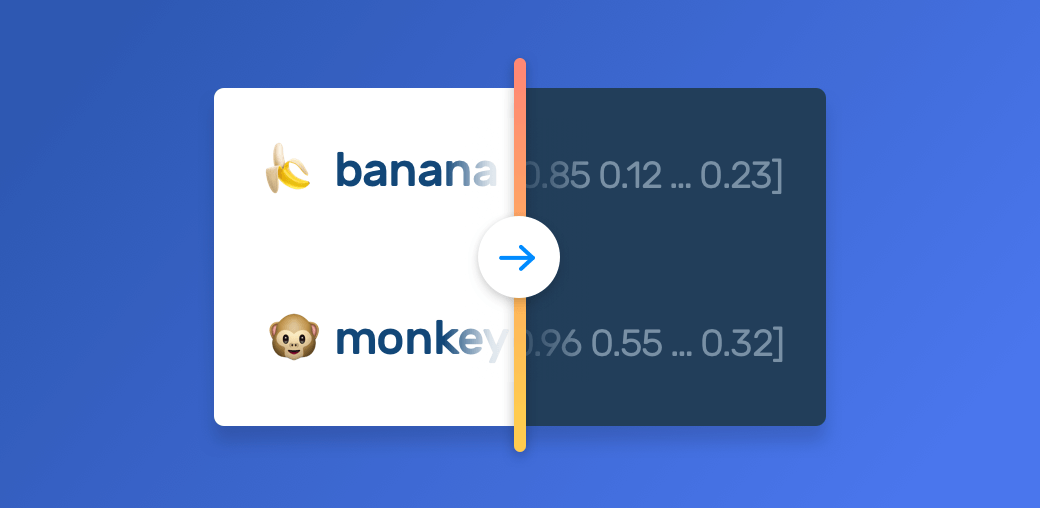

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tweet=pd.read_csv("/content/tweet_emotions.csv")
tweet.shape


(40000, 3)

In [ ]:
tweet.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
tweet['sentiment'].value_counts()  #Counting the uniques classes and data associated to them

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [ ]:
#Let us take the top 3 categories and leave out the rest.
shortlist = ['neutral', "happiness", "worry"]
df_subset = tweet[tweet['sentiment'].isin(shortlist)]
df_subset.shape

(22306, 3)

#Text pre-processing:

Tweets are different. Somethings to consider:

Removing @mentions, and urls perhaps?

using NLTK Tweet tokenizer instead of a regular one

stopwords, numbers as usual.

In [ ]:
#strip_handles removes personal information such as twitter handles, which don't
#contribute to emotion in the tweet. preserve_case=False converts everything to lowercase.
tweets = TweetTokenizer(strip_handles=True,preserve_case=False)
mystopwords = set(stopwords.words("english"))

#Function to tokenize tweets, remove stopwords and numbers. 
#Keeping punctuations and emoticon symbols could be relevant for this task!
def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        #Nested function that removes stopwords and digits from a list of tokens
        return [token for token in tokens if token not in mystopwords and not token.isdigit()]
    #This return statement below uses the above function to process twitter tokenizer output further. 
    return [remove_stops_digits(tweets.tokenize(content)) for content in texts]

#df_subset contains only the three categories we chose. 
mydata = preprocess_corpus(df_subset['content'])
mycats = df_subset['sentiment']
print(len(mydata), len(mycats))

22306 22306


In [ ]:
#Split data into train and test, following the usual process
train_data, test_data, train_cats, test_cats = train_test_split(mydata,mycats,random_state=1234)

#prepare training data in doc2vec format:
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(train_data)]
#Train a doc2vec model to learn tweet representations. Use only training data!!
model = Doc2Vec(vector_size=50, alpha=0.025, min_count=5, dm =1, epochs=100)
model.build_vocab(train_doc2vec)
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)
model.save("d2v.model")
print("Model Saved")

Model Saved


In [ ]:
#Infer the feature representation for training and test data using the trained model
model= Doc2Vec.load("d2v.model")
#infer in multiple steps to get a stable representation. 
train_vectors =  [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in train_data]
test_vectors = [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in test_data]

#Use any regular classifier like logistic regression
from sklearn.linear_model import LogisticRegression

myclass = LogisticRegression(class_weight="balanced") #because classes are not balanced. 
myclass.fit(train_vectors, train_cats)

preds = myclass.predict(test_vectors)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_cats, preds))

#print(confusion_matrix(test_cats,preds))

              precision    recall  f1-score   support

   happiness       0.46      0.55      0.50      1331
     neutral       0.48      0.55      0.51      2143
       worry       0.57      0.42      0.49      2103

    accuracy                           0.50      5577
   macro avg       0.51      0.51      0.50      5577
weighted avg       0.51      0.50      0.50      5577

